# 1. Author

**Student Name:** Daniel Elston

**Student Number:** 210720147

# 2. Problem Formulation

This machine learning model aims to take an audio file as an input and return a name classification as an output. The model will be trained using a dataset of recorded 'hums' and 'whistles' to the Harry Potter and Star Wars theme song. This will allow users to hum or whistle to the tune of an unknown song, then the model will classify the input and return a name classifcation


In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import librosa.display
import math
import soundfile as sf
import matplotlib.style as ms
from tqdm import tqdm

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data is loaed in. For this problem, a dataset consisting of many WAV files, each with either a hum or a whistle to the Harry Potter theme song or the Star Wars theme song.

In [2]:
pathall = '/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio'

In [3]:
sample_pathall = '/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/*.wav'
files_all = glob.glob(sample_pathall)

len(files_all)

747

# 3. Machine Learning Pipeline

The machine learning pipeline below consists of audio files as an input with transformations in the form of audio feature extraction. Machine learning models are trained with useful extracted features and executed. The output is a classification of song recogonition.

# 4. Transformation Stage

The input for this model is a dataset containing 747 audio files. There are 4 types of file, each file is either a student humming or whistling to either the Harry Potter or Star Wars theme song. The features extracted include pitch, signal mean and std, harmonic mean and others. The features are analysed using confusion matrix.

At this stage, features of each audio file are extracted for later use. The first cell extracts pitch and fundemental frequency.

In [4]:
def getPitch(x,fs,winLen=0.02):
  
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

This cell extracts features such as the mean and standard deviation of each audio file. Other features include the root mean square error metrics, the harmonic metrics and librosa auto correlation metrics.

In [5]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    mean = np.mean(abs(x))
    std = np.std(x)

    rmse = librosa.feature.rms(x + 0.0001)[0]
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)

    y_harmonic, y_percussive = librosa.effects.hpss(x)
    mean_harm = np.mean(y_harmonic)

    autocorr = librosa.core.autocorrelate(x)
    max_autocorr = np.max(autocorr)

    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [y_harmonic, y_percussive, mean_harm]
    X.append(xi)
    y.append(yi)

  return np.array(X), np.array(y)

Each feature extracted was saved as a seperate text file and loaded in from the same filepath as the rest of the data. This saves computing power.

In [6]:
with open('/content/drive/MyDrive/Data/MLEndHW_pub/f_og.txt', 'rb') as filepath:
  f_og=pickle.load(filepath)

In [7]:
with open('/content/drive/MyDrive/Data/MLEndHW_pub/f_rmse.txt', 'rb') as filepath:
  f_rmse=pickle.load(filepath)

In [8]:
with open('/content/drive/MyDrive/Data/MLEndHW_pub/f_harm2.txt', 'rb') as filepath:
  f_harm=pickle.load(filepath)

Each feature is added to a dataframe for easy visualisation of resulting features extracted.

# 5. Modelling

The SVM, RandomForestClassifier (RFC) and XGBoost Classifier (XGBC) from Sklearn will be used to train our model and execute the results over all audio files. Using extracted features, machine learning models are trained and executed. 

SVM is a support vector machine that seperates the data based on a regression line that fits the data the best. Once this regression has taken place, the SVM classifies each data point based on which side of the line it lies on.

The RFC constructs many decision trees tasked with classifying each audio feature. Many iterations of the classification algorithm take place, then the RFC takes an average classification as the result.

The XGBClassifier allows the dataset to be treated as a model and therefore enables it to be classified.

# 6. Methodology

The useful features extracted will now be passed through various modules in order to train our model. Validation sets of the data extracted will be used to test the model and produce a result of how well the model classifies the data for each song type.

Model performances will be validated using metrics such as their accuracy, f1 scores, recall scores, precision scores and finally, their confusion matrices. Model Accuracy, is the most important for this report, as it will tell us how often the classifier is correct in identifying the song name. The f1 score is the mean ratio of the models performance using precision and recall. 

Confusion matrices are shown to visualise the target classification predicted by the model compared to the actual classification. 

# 7. Dataset

The dataset being used to train each model is that of the audio files features that have been extracted. These include power, pitch mean, pitch std, voiced frequency, signal mean, signal standard deviation, root mean square error mean, root mean square error standard deviation and harmonic mean.

Two random files are loaded and their paths are shown.

In [9]:
n=4
m=5
fs = None
x, fs = librosa.load(files_all[n],sr=fs)
x2, fs2 = librosa.load(files_all[m],sr=fs)
t = np.arange(len(x))/fs

print(files_all[n])
print(files_all[m])

/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/S5_hum_1_Potter.wav
/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/S4_hum_1_Potter.wav


Here is an example of the raw data we are working with. The files shown below are randomly chosen from a large collection of 747 files.

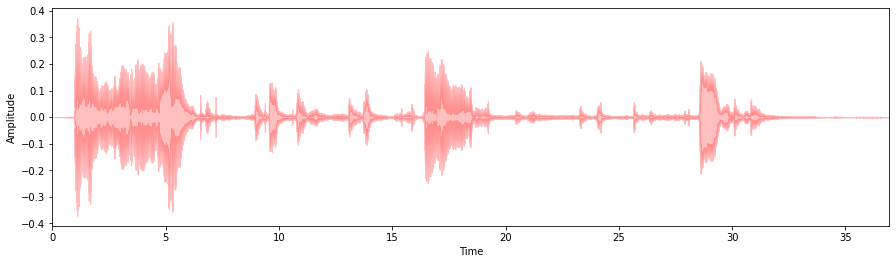

In [10]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x, max_sr=1000, alpha=0.25, color='r')
plt.ylabel('Amplitude')
plt.show()

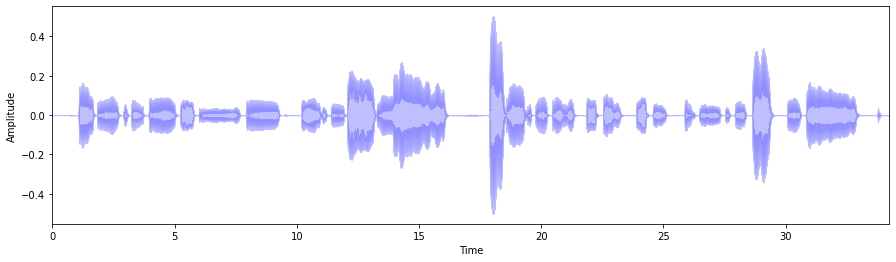

In [11]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x2, max_sr=1000, alpha=0.25, color='b')
plt.ylabel('Amplitude')
plt.show()

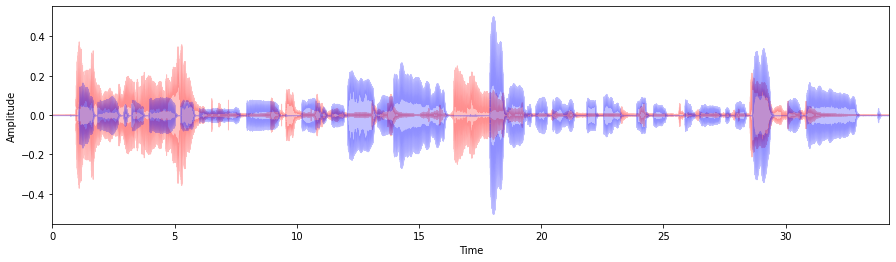

In [12]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x, max_sr=1000, alpha=0.25, color='r')
librosa.display.waveplot(x2, max_sr=1000, alpha=0.25, color='b')
plt.ylabel('Amplitude')
plt.show()

The code below retreives all files by name.

In [13]:
all_table = [] 

for file in files_all:
  file_name = file.split('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1]
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0]
  all_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

The files are put into a dataframe to easily see their titles and details.

In [14]:
all_df = pd.DataFrame(all_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
all_df

,participant,interpretation,number,song
file_id,,,,
S1_hum_2_Potter.wav,S1,hum,2,Potter
S2_whistle_2_Potter.wav,S2,whistle,2,Potter
S5_hum_2_Potter.wav,S5,hum,2,Potter
S3_hum_1_Potter.wav,S3,hum,1,Potter
S5_hum_1_Potter.wav,S5,hum,1,Potter
...,...,...,...,...
S222_hum_2_StarWars.wav,S222,hum,2,StarWars
S219_hum_3_StarWars.wav,S219,hum,3,StarWars
S218_whistle_2_StarWars.wav,S218,whistle,2,StarWars


All audio features extracted are put into dataframes and combined. Each file is either a Potter file (True) or a Starwars file (False).

In [15]:
z = f_og
z2 = z[0]
columns2 = ['Power', 'Pitch_mean', 'Pitch_std', 'Voiced_fr', 'Mean', 'Std']
df_og = pd.DataFrame(z2, columns=columns2)

In [16]:
y = f_rmse
y2 = y[0]
columns1 = ['0','RMS_mean', 'RMS_std']
df_rms0=pd.DataFrame(y2, columns=columns1)
df_rms = df_rms0.drop(columns='0', axis=1)

In [17]:
h = f_harm[:,2]
columns3 = ['Harm_mean']
df_harm= pd.DataFrame(h, columns=columns3)

In [18]:
labels = z[-1]

In [19]:
dfsub1 = df_rms['RMS_mean']
dfsub2 = df_rms['RMS_std']

Here is the resultant audio feature dataframe.

In [20]:
df0 = df_og
df1 = df0.assign(RMS_mean = dfsub1)
df2 = df1.assign(RMS_std = dfsub2)
df3 = df2.assign(Harmonic_mean = df_harm)
df = df3.assign(Labels = labels)
display(df.head())
print(df.shape)

,Power,Pitch_mean,Pitch_std,Voiced_fr,Mean,Std,RMS_mean,RMS_std,Harmonic_mean,Labels
0,0.001961,107.628769,14.832539,0.461431,0.024760,0.044287,0.0321113,0.0304978,-9.06551e-06,True
1,0.037227,396.012292,40.644200,0.766846,0.124098,0.192943,0.141386,0.131258,-3.79768e-05,True
2,0.021068,334.779764,47.934276,0.932806,0.089853,0.145148,0.105724,0.0994181,-5.39729e-05,True
3,0.093276,184.280074,27.611400,0.935164,0.242634,0.305412,0.272731,0.137324,-1.90273e-06,True
4,0.013179,328.960849,54.961412,0.839824,0.054276,0.114798,0.064197,0.0951398,-5.11787e-05,True


(747, 10)


A correlation matrix is used to find which features are important to this analysis.

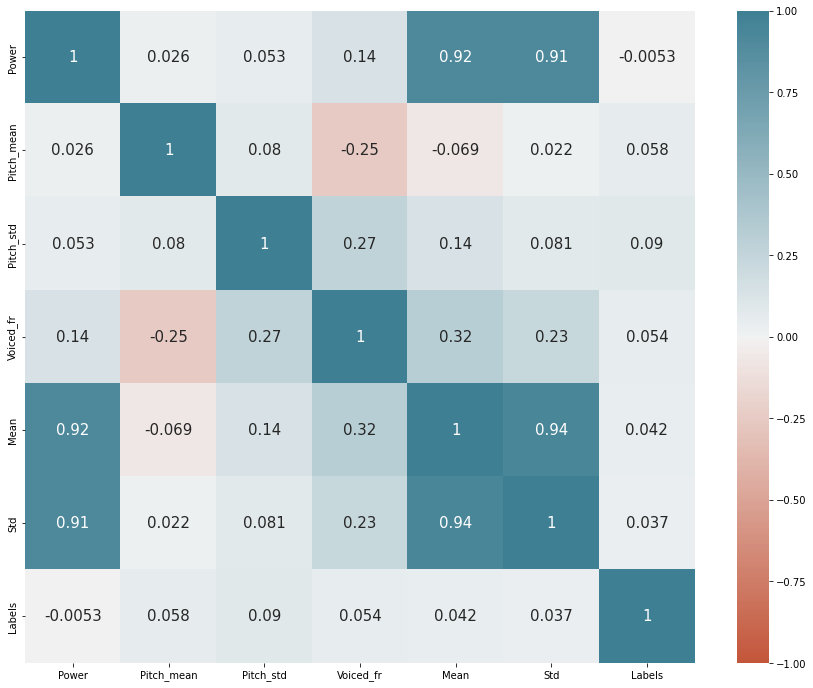

In [21]:
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
plt.show()

A principle component analysis (PCA) is conducted to check for any obvious regions of seperation in the datasets.

In [22]:
scaler = StandardScaler()
pca = PCA(n_components = 2)

df_z = StandardScaler().fit_transform(df)
df_z1 = pd.DataFrame(df_z)

df_v = df_z1.iloc[:,:-1]

pca_data = pca.fit_transform(df_v)
pca_df0 = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

Labels = df[['Labels']]

pca_df = pca_df0.assign(Labels=Labels)

pca_df.head()

,PC1,PC2,Labels
0,-3.727879,0.641030,True
1,0.267450,0.684315,True
2,-0.748411,-0.844228,True
3,3.409617,-1.044598,True
4,-1.652448,-0.557857,True


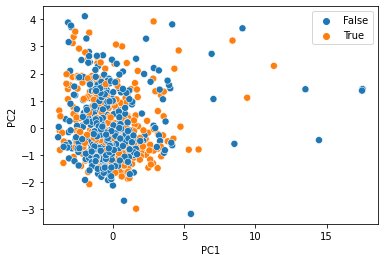

In [23]:
sns.scatterplot(x=pca_df.PC1, y=pca_df.PC2, hue=labels, s=50)
plt.show()

With a PCA of all the features extracted, its can be seen there are no ovbious regions of seperation.

# 8. Results

The results of the model are shown below. To begin, features deemed important to classification are extracted from the dataframe and normalised.

In [24]:
scaler = StandardScaler()

testy = df['Labels'].to_numpy()
xtest2 = df[['Std','Mean','Pitch_mean','Voiced_fr','Pitch_std','Power']].to_numpy()
scaler.fit(xtest2)
xte = scaler.transform(xtest2)

The dataset is split into training and validation sets. Each training set will be used to train the model, then the validation sets will be used to test how well the model fits the data.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(xte,testy,test_size=0.25)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((560, 6), (187, 6), (560,), (187,))

Using the SVM module, the model is now trained and executed.

In [26]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=model.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=model.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=model.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=model.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=model.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=model.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=model.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=model.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=model.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=model.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.675
f1 Score: 0.6654411764705882
Recall Score: 0.6678966789667896
Precision Score: 0.663003663003663


The validation data metrics are:
Accuracy Score: 0.5240641711229946
f1 Score: 0.5388601036269429
Recall Score: 0.5416666666666666
Precision Score: 0.5360824742268041


The support vectors are (483, 6) 

Training confusion matrix:
 [[197  92]
 [ 90 181]]

Validation confusion matrix:
 [[46 45]
 [44 52]]

Normalised training confusion matrix:
 [[0.6816609  0.3183391 ]
 [0.33210332 0.66789668]]

Normalised validation confusion matrix:
 [[0.50549451 0.49450549]
 [0.45833333 0.54166667]]



The results of the SVM classifier on accuracy of the training dataset are poor. Around 69% of the time it returns the correct label. The results of accuracy on the validation  are even worse, only returning the correct label approximately 56% of the time. In deployment, this alogrithm would not work.

The results of the confusion matrices are poor again showing great uncertainty in our models decisions.

Using the RFC, the model is now trained and executed.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=300)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_val)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=clf.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.6
f1 Score: 0.5590551181102362
Recall Score: 0.5239852398523985
Precision Score: 0.5991561181434599


The validation data metrics are:
Accuracy Score: 0.5401069518716578
f1 Score: 0.5
Recall Score: 0.4479166666666667
Precision Score: 0.5657894736842105


The support vectors are (483, 6) 

Training confusion matrix:
 [[194  95]
 [129 142]]

Validation confusion matrix:
 [[58 33]
 [53 43]]

Normalised training confusion matrix:
 [[0.67128028 0.32871972]
 [0.47601476 0.52398524]]

Normalised validation confusion matrix:
 [[0.63736264 0.36263736]
 [0.55208333 0.44791667]]



The results of the RFC classifier on accuracy of the training dataset are poor. Around 61% of the time it returns the correct label. The results of accuracy on the validation are slightly better, returning the correct label approximately 65% of the time. In deployment, again, this alogrithm would not work. The confusion matrices show scattered results once again. The validation matrix is better but still, the results are poor.

Using an XGB classifier, the model is trained and executed.

In [28]:
xgbc = XGBClassifier()
XGBClassifier(base_score=0.5, objective='multi:softprob') 

xgbc.fit(X_train, y_train)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=xgbc.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=xgbc.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.8946428571428572
f1 Score: 0.8936936936936937
Recall Score: 0.915129151291513
Precision Score: 0.8732394366197183


The validation data metrics are:
Accuracy Score: 0.6096256684491979
f1 Score: 0.6137566137566137
Recall Score: 0.6041666666666666
Precision Score: 0.6236559139784946


The support vectors are (483, 6) 

Training confusion matrix:
 [[253  36]
 [ 23 248]]

Validation confusion matrix:
 [[56 35]
 [38 58]]

Normalised training confusion matrix:
 [[0.87543253 0.12456747]
 [0.08487085 0.91512915]]

Normalised validation confusion matrix:
 [[0.61538462 0.38461538]
 [0.39583333 0.60416667]]



The results of the XGB classifier on accuracy of the training dataset are far better than the other classifiers. Around 89% of the time it returns the correct label. The results of accuracy on the validation however, are poor, returning the correct label approximately 57% of the time. The large difference in accuracies is likely due to overfitting of the training data. In deployment, again, this alogrithm would not work. The validation matrix is quite even again, showing the model is struggling to classify files correctly.

# 9. Conclusion

The SVM classifier performed better than the RFC classifier, but only slightly. Improvements could include alligning audio files to match length (time) of each recording, allowing for easier pattern recogonition. I had attempted to use librosas auto correlation function however the results required to much RAM and therefore results could not be saved. The XGB classifier has been disregarded from this conclusion as the training dataset was over fitted and thus not a reliable result.

It is suprising that better classification could not take place given a relatively good dataset. The dataset is large and varied, which is expected to improve results. Potential problems could include variance of recording devices and background noise.

To improve the dataset and therefore perhaps results, all audio recordings could be done on one of the three most popular phones (Iphone, Samsung, Huawei). This would provide a more uniform mode of recording and would simulate real world practices better.